In [1]:
# import dependencies
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader , random_split
from torchvision import datasets
from torchvision.transforms import ToTensor, transforms, Lambda
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
import time
from torch.utils.data import ConcatDataset, DataLoader

## CHOOSE DEVICE

In [2]:
# use gpu
use_cuda = True
if use_cuda and torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')
device

device(type='cuda')

## MODEL

In [3]:
# modal definition
class AlexnetTS(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256*7*7, 1000),
            nn.ReLU(inplace=True),

            nn.Dropout(0.5),
            nn.Linear(in_features=1000, out_features=256),
            nn.ReLU(inplace=True),

            nn.Linear(256, output_dim)
            )

    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

## LABEL MAPPING

In [4]:
''' the actual label turned into string, stored and sorted in Lexicographic order in list. Then the index of the list
    used for training. We don't know exactly why it was trained in such a way. But, the mapping is given below'''

def label_map(label) :
  num = range(43)
  labels = []
  for i in num:
      labels.append(str(i))
  labels = sorted(labels)
  for i in num:
      labels[i] = int(labels[i])
  return labels.index(label)


## MODEL INSTANCE

In [5]:
# create an instance of the modal
model = AlexnetTS(output_dim=43)
model.load_state_dict(torch.load("pytorch_classification_alexnetTS.pth", map_location= torch.device(device=device)))
model.to(device)

AlexnetTS(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=12544, out_features=1000, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5,

## LOAD TEST AND TRAINING DATA

In [6]:
# change the the image to tensor and resize them 112x112 pixels
data_transforms = transforms.Compose([
    transforms.Resize([112, 112]),
    transforms.ToTensor(),
   ])

# change the label since the data is trained on the different label
target_transform =  Lambda(lambda y : torch.tensor(label_map(y)))

# load the training and test set
train_data =  datasets.GTSRB(root = "GTSRB_train", download=True, split='train', transform=data_transforms, target_transform= target_transform)
test_data  =  datasets.GTSRB(root = "GTSRB_test",  download=True, split='test',  transform=data_transforms, target_transform= target_transform)

# further divide the test data and train data
train_adv, train_pure        = random_split(train_data, lengths= [0.5, 0.5])  # train_adv will be used for generating adversarial example
attack_set, test_set         = random_split(test_data, lengths= [0.5, 0.5])   # attack is used for test against adversarial

# create dataloader object
train_adv_loader  = DataLoader(train_adv,  batch_size=1, shuffle= True)
train_pure_loader = DataLoader(train_pure, batch_size=1, shuffle= True)
attack_loader     = DataLoader(attack_set, batch_size=1,  shuffle = True)
test_loader       = DataLoader(test_set, batch_size=1,  shuffle = True)

## DATASET CONTENT

The number of training samples: 26640
The number of test data:        12630
The total number of examples:   39270


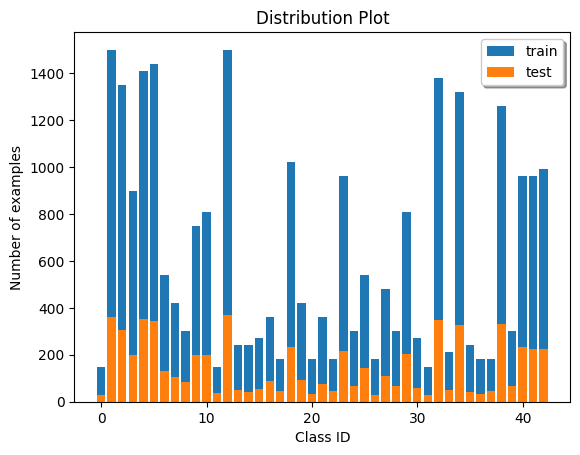

In [7]:
# training and testing data figures
numClasses = 43
print(f"The number of training samples: {len(train_data)}")
print(f"The number of test data:        {len(test_data)}")
print(f"The total number of examples:   {len(test_data)+len(train_data)}")

train_loader  = DataLoader(train_data,  batch_size=1, shuffle= True)
test_loader2  = DataLoader(test_data,   batch_size=1, shuffle= True)

train_hist = [0]*numClasses
for i, (image, label) in enumerate(train_loader):
  train_hist[label[0].item()]+=1

test_hist = [0]*numClasses
for i, (image, label) in enumerate(test_loader):
  test_hist[label[0].item()]+=1

plt.bar(range(numClasses), train_hist, label="train")
plt.bar(range(numClasses), test_hist, label="test")
legend = plt.legend(loc='upper right', shadow=True)
plt.title("Distribution Plot")
plt.xlabel("Class ID")
plt.ylabel("Number of examples")
plt.savefig("train_val_split.png", bbox_inches = 'tight', pad_inches=0.5)

## GENERATE ADVERSERIAL EXAMPLE

In [8]:
## Adverserial Example generation

# Fast gradient sign method (FGSM)
def attack_FGSM(x, y, model, loss_fn, epsilon, device=None):
  x.requires_grad = True
  y_pred = model(x)
  model.zero_grad()
  loss = loss_fn(y_pred[0],y)
  loss.backward()
  x_adv = x + epsilon * x.grad.sign()
  x_adv = torch.clamp(x_adv, 0, 1)
  return x_adv

# Projected gradient decent method (PGD), it is also called iterative FGSM
def attack_PGD(x, y, model, loss_fn, epsilon, alpha, num_iteration, device = None):
  original_x = x
  for i in range(num_iteration) :
    x.requires_grad = True
    y_pred = model(x)
    model.zero_grad()
    loss = loss_fn(y_pred[0], y)
    loss.backward()
    x = x + alpha * x.grad.sign()
    perturb = torch.clamp(x-original_x, min= -epsilon, max =  epsilon)
    x = torch.clamp(original_x + perturb, min=0.0, max=1.0).detach_()
  return x

##BEFORE AND AFTER

In [9]:
# visual check if the attack is changing the image significantly. we display some examples here
loss_fn = nn.CrossEntropyLoss()
epsilon = 0.12
alpha = 0.01
example = []
ad_example = []

# FSGM
for i, (images, labels) in enumerate(attack_loader):
  if i== 10:
    break
  images, labels = images.to(device), labels.to(device)
  adv_image = attack_FGSM(x=images, y=labels, loss_fn= loss_fn, epsilon= epsilon, model=model, device=device)
  example.append(images)
  ad_example.append(adv_image)

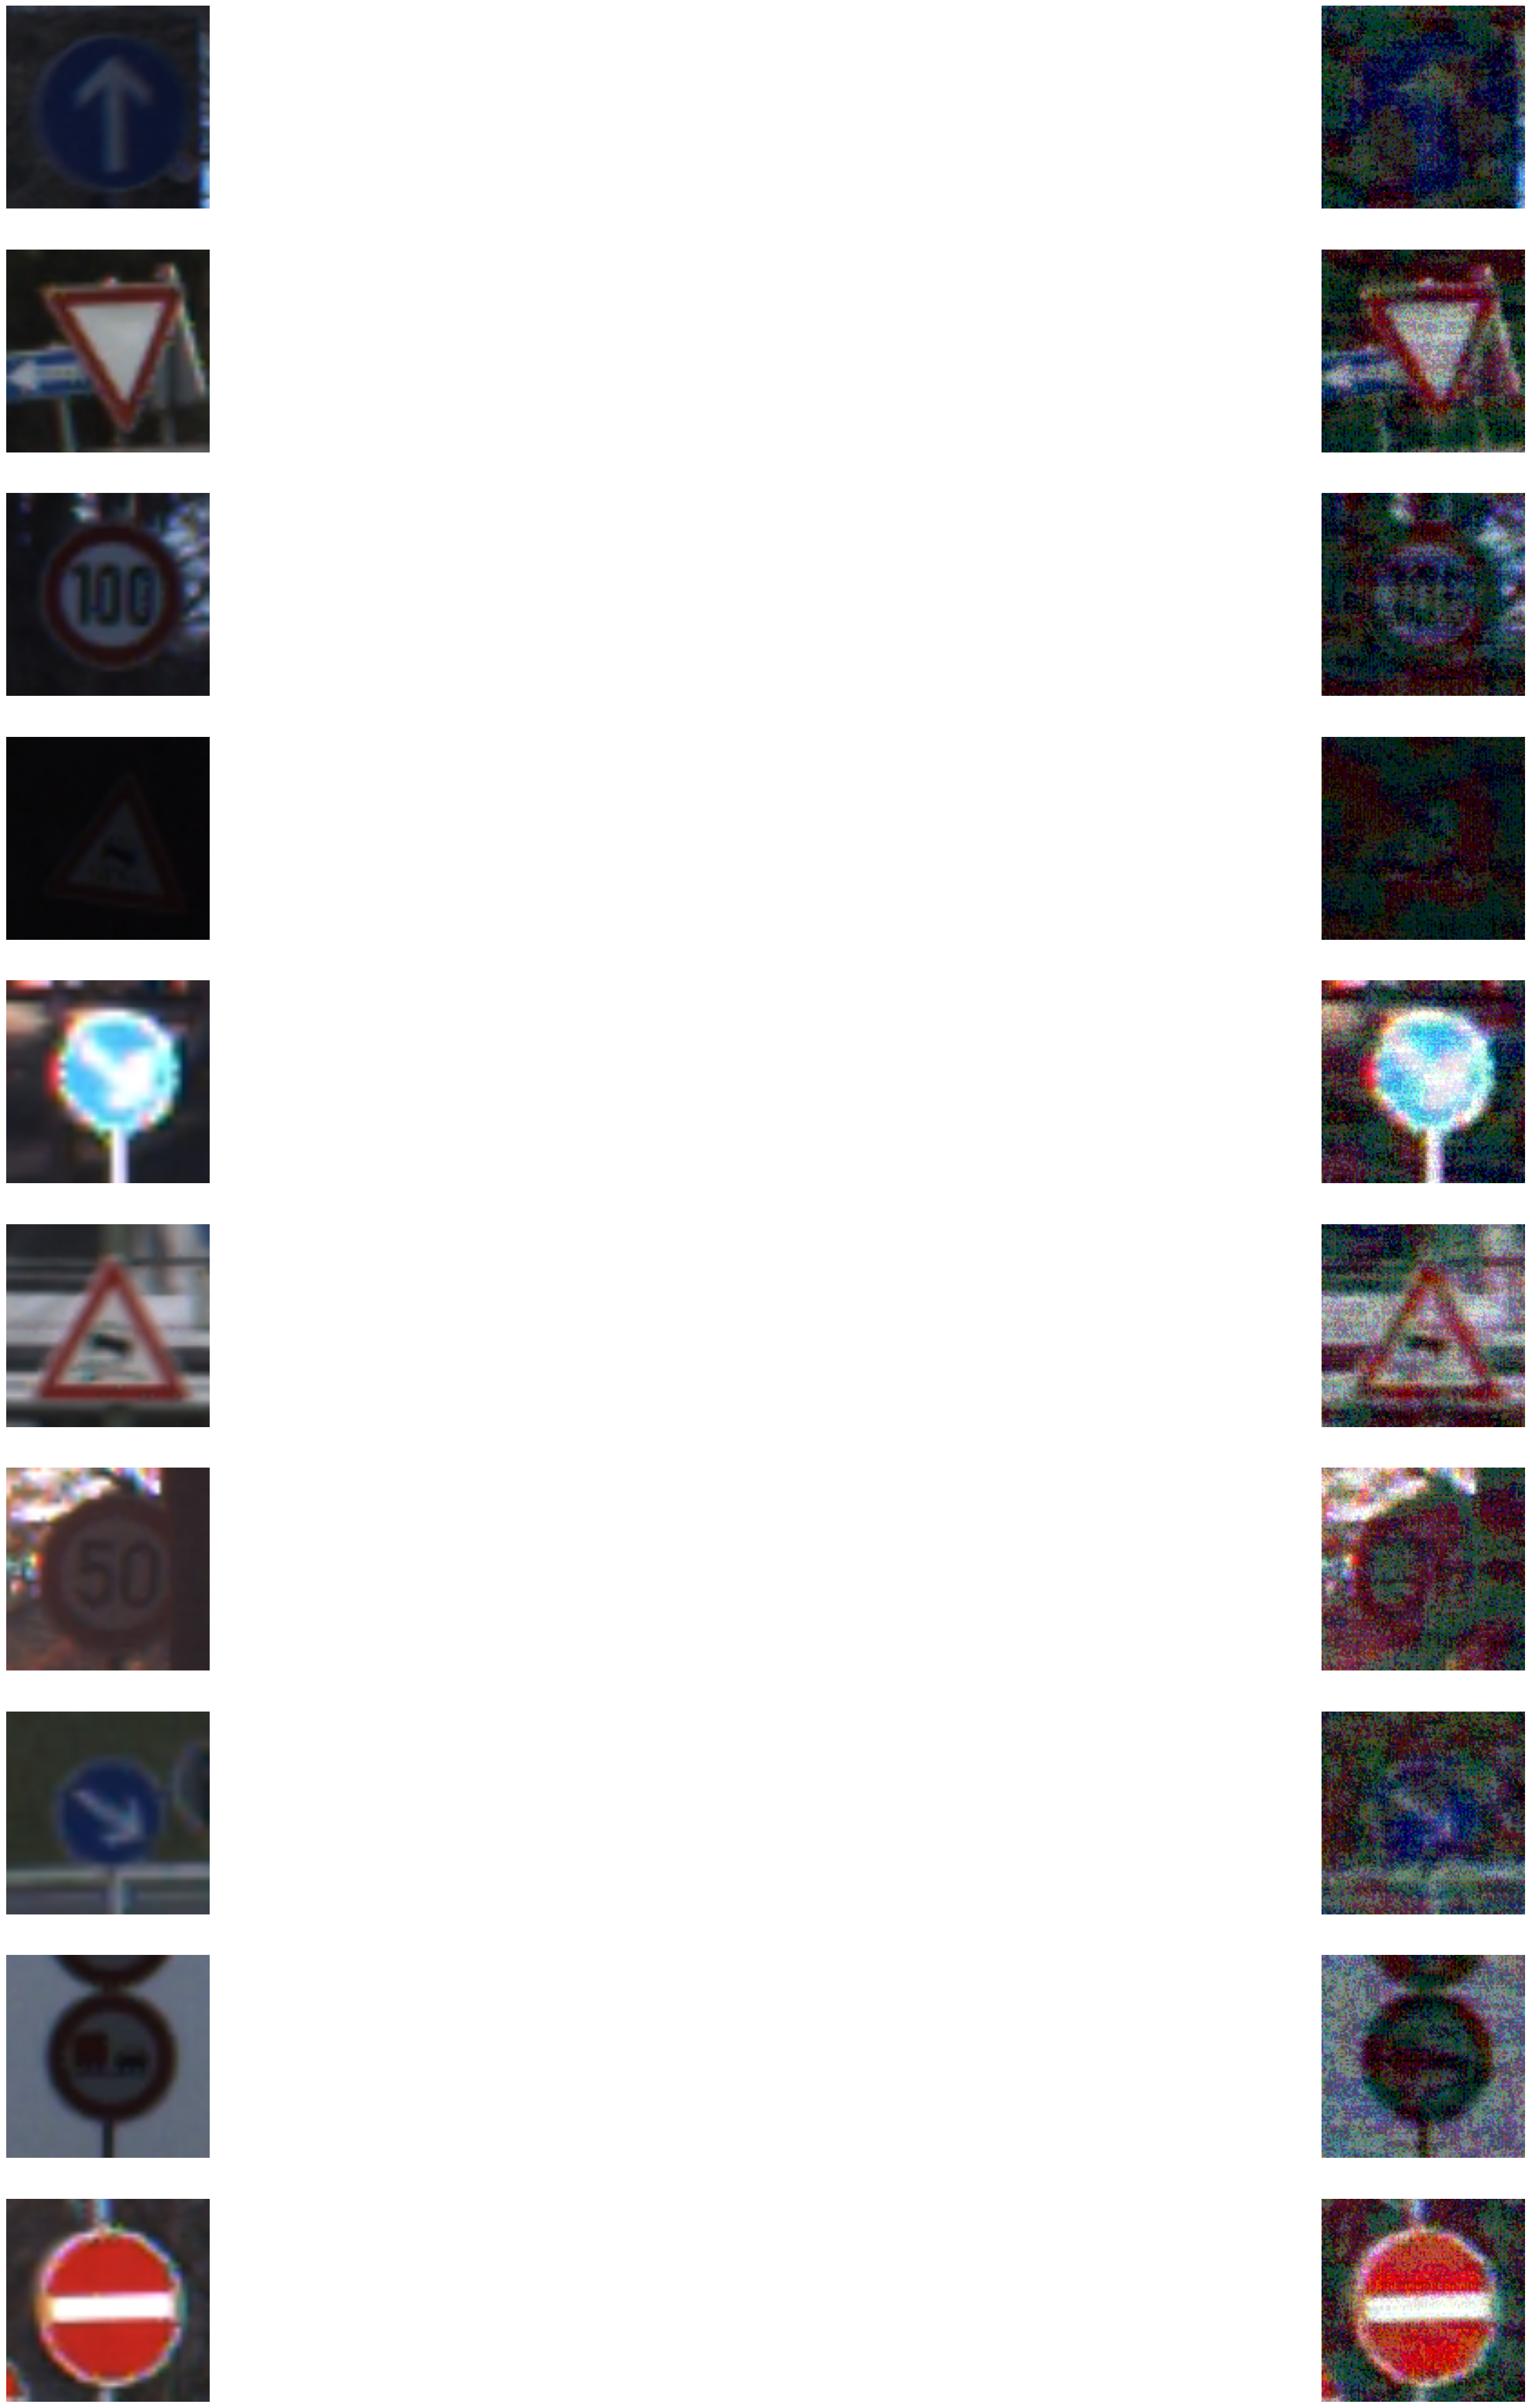

In [10]:
# display before and after for FSGM
fig, axes = plt.subplots(nrows =10, ncols = 2, figsize=(50, 50),gridspec_kw={'width_ratios': [1, 1]})
for i in range(10) :
  img_np = example[i][0].detach().cpu().numpy().transpose((1, 2, 0))
  axes[i, 0].imshow(img_np)
  axes[i, 0].axis('off')

for i in range(10) :
  img_np = ad_example[i][0].detach().cpu().numpy().transpose((1, 2, 0))
  axes[i-10, 1].imshow(img_np)
  axes[i-10, 1].axis('off')
plt.savefig("before_after_FSGM.png", bbox_inches = 'tight', pad_inches=0.5)

In [11]:
# PGD
example2    = []
ad_example2 = []
for i, (images, labels) in enumerate(test_loader):
  if i== 10:
    break
  images, labels = images.to(device), labels.to(device)
  adv_image = attack_PGD(x=images, y=labels, loss_fn= loss_fn, epsilon= epsilon, model=model, device=device,alpha=alpha, num_iteration=10)
  example2.append(images)
  ad_example2.append(adv_image)

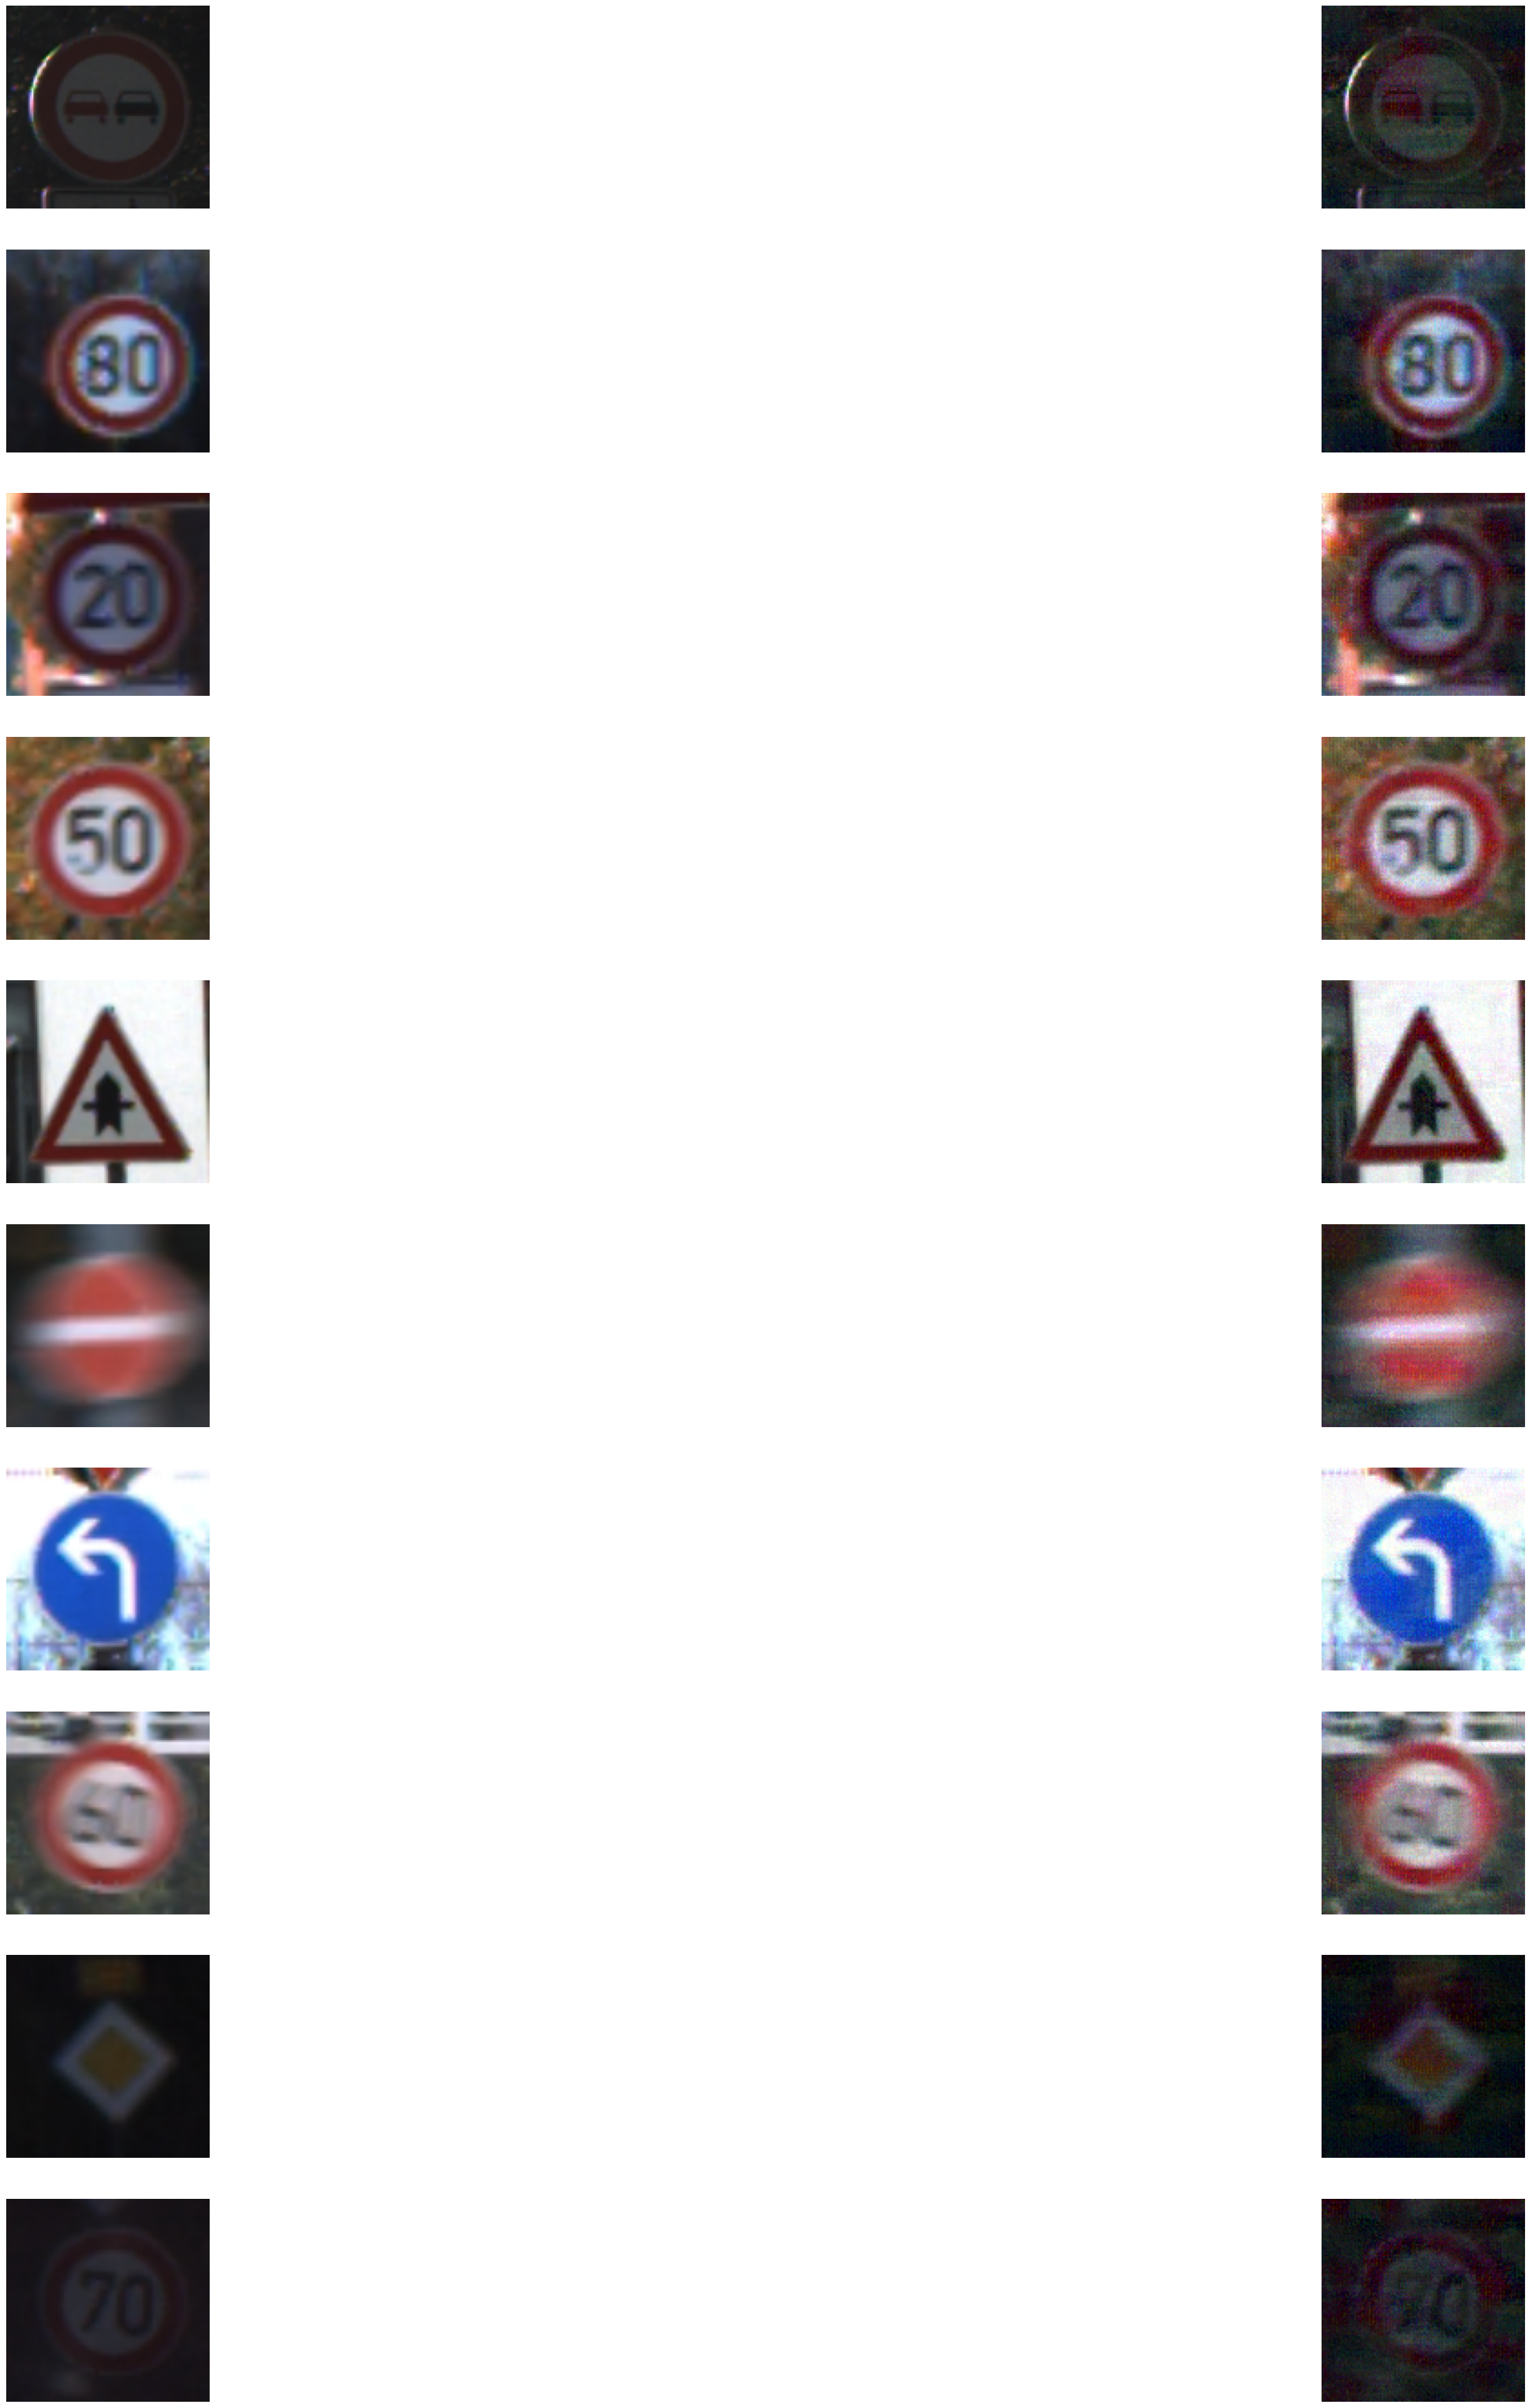

In [12]:
# display before and after for PGD
fig, axes = plt.subplots(nrows =10, ncols = 2, figsize=(50, 50),gridspec_kw={'width_ratios': [1, 1]})

for i in range(10) :
  img_np = example2[i][0].detach().cpu().numpy().transpose((1, 2, 0))
  axes[i, 0].imshow(img_np)
  axes[i, 0].axis('off')

for i in range(10) :
  img_np = ad_example2[i][0].detach().cpu().numpy().transpose((1, 2, 0))
  axes[i-10, 1].imshow(img_np)
  axes[i-10, 1].axis('off')

plt.savefig("before_after_PGD.png", bbox_inches = 'tight', pad_inches=0.5)

## FSGM AND PGD ATTACK

In [13]:
def attack(model, epsilons, loss_fn, alpha, data_loader) :
  model.eval()  # Put the network in eval mode
  accuracy  = []           # accuracy for each epsilon value FSGM
  loss      = []
  accuracy2 = []           # accuracy for PGD
  loss2     = []

  # the accuracy of the model attacked by FSGM using different epsilon
  for e in epsilons :
    correct_total = 0
    for i, (images, labels) in enumerate(data_loader):
      images, labels = images.to(device), labels.to(device)
      adv_images = attack_FGSM(x=images, y=labels, loss_fn= loss_fn, epsilon= e, model=model, device=device) # generate adverserial example from image
      y_test_pred = model(adv_images)
      y_pred_softmax = torch.log_softmax(y_test_pred[0], dim=1)
      y_pred_tags = torch.argmax(y_pred_softmax, dim=1)
      correct_total += torch.sum(torch.eq(y_pred_tags, labels)).item()
    accuracy.append(correct_total / len(attack_set))
    loss.append((len(attack_set)-correct_total) / len(attack_set))
    print(f'Accuracy on the attack set: {correct_total / len(attack_set):.3f}')

  for e in epsilons :
    correct_total = 0
    for i, (images, labels) in enumerate(data_loader):
      images, labels = images.to(device), labels.to(device)
      adv_images = attack_PGD(x=images, y=labels, loss_fn= loss_fn, epsilon= e, model=model, device=device, num_iteration=10, alpha=alpha) # generate adverserial example from image
      y_test_pred = model(adv_images)
      y_pred_softmax = torch.log_softmax(y_test_pred[0], dim=1)
      y_pred_tags = torch.argmax(y_pred_softmax, dim=1)
      correct_total += torch.sum(torch.eq(y_pred_tags, labels)).item()
    accuracy2.append(correct_total / len(attack_set))
    loss2.append((len(attack_set)-correct_total) / len(attack_set))
    print(f'Accuracy on the attack set: {correct_total / len(attack_set):.3f}')


  return {"accuracy" : accuracy, "loss" : loss, "accuracy2" : accuracy2, "loss2" : loss2}


In [14]:
# the accuracy of the model attacked by PGD using different epsilon
loss_fn = nn.CrossEntropyLoss()
epsilons = [0, 0.004, 0.008, 0.012, 0.016, 0.02]        #TODO: WE NEED TO CHOOSE A PROPER EPSILON VALUES FOR THE ATTACK
alpha = 0.001                                       #TODO: WE NEED TO CHOOSE A PROPER ALPHA VALUE FOR PGD

result = attack(model=model, epsilons = epsilons, loss_fn = loss_fn, alpha = alpha, data_loader = attack_loader)
accuracy   = result['accuracy']
loss       = result['loss']
accuracy2  = result['accuracy2']
loss2      = result['loss2']

Accuracy on the attack set: 0.953
Accuracy on the attack set: 0.705
Accuracy on the attack set: 0.570
Accuracy on the attack set: 0.501
Accuracy on the attack set: 0.459
Accuracy on the attack set: 0.429
Accuracy on the attack set: 0.953
Accuracy on the attack set: 0.616
Accuracy on the attack set: 0.445
Accuracy on the attack set: 0.412
Accuracy on the attack set: 0.412
Accuracy on the attack set: 0.412


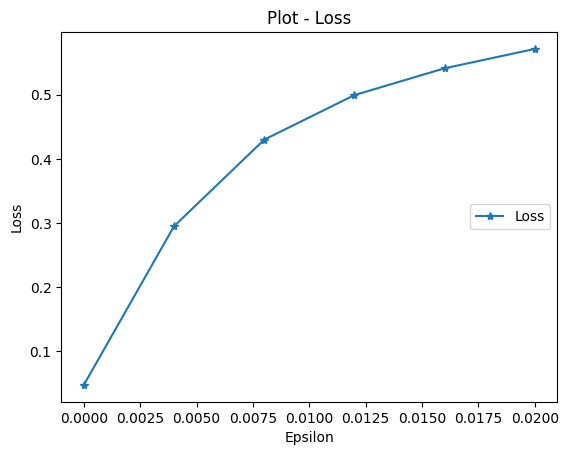

In [15]:
# Plot the result of the attack (accuracy vs epsilon) and (loss vs espislon)
# Loss plot
plt.plot(epsilons, loss, "*-", label="Loss")
plt.title("Plot - Loss")
plt.xlabel("Epsilon")
plt.ylabel("Loss")
plt.legend(loc='center right', shadow=False)
plt.savefig("loss_plot_FSGM.png", bbox_inches = 'tight', pad_inches=0.5)

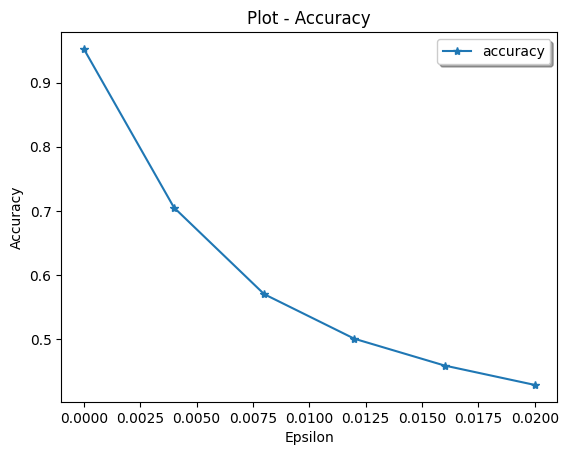

In [16]:
# Accuracy plot
plt.plot(epsilons, accuracy, "*-", label="accuracy")
plt.title("Plot - Accuracy")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend(loc='upper right', shadow=True)
plt.savefig("accurac_plot_FSGM.png", bbox_inches = 'tight', pad_inches=0.5)

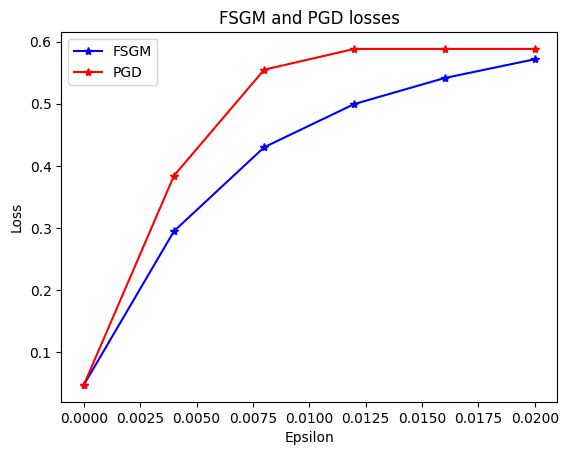

In [17]:
# FSGM vs PGD
plt.plot(epsilons, loss, "*-", label='FSGM', color='blue', )
plt.plot(epsilons, loss2, "*-", label='PGD', color='red')
plt.xlabel("Epsilon")
plt.ylabel("Loss")
plt.title("FSGM and PGD losses")
plt.legend()
plt.savefig("FSGM_and_PGD_losses.png", bbox_inches = 'tight', pad_inches=0.5)

## ADVERSARIAL TRAINING

In [18]:
# generate adverserial example for training

"""This use class his a child class of pytrochs Datasets. it uses other dataset called train_adv to generate an adverserial example for pure example"""

class CustomGTSRB(Dataset):
    def __init__(self, dataset, isFGDM, model, loss_fn, device=None, transform=None, target_transform=None):
        self.dataset = dataset
        self.isFGDM = isFGDM
        self.transform = transform
        self.target_transform = target_transform
        self.model = model
        self.loss_fn = loss_fn
        self.device = device

    def __len__(self):
        return self.dataset.__len__()

    def __getitem__(self, idx):
        image, label= self.dataset.__getitem__(idx)
        image = image.to(self.device)
        label = label.to(device) # TODO: check if i need to change label to tensor

        if self.isFGDM :
          image = self.attack_FGSM(x=image, y=label, loss_fn= self.loss_fn, epsilon= 0.004, model=model, device=self.device)
        else :
          image = self.attack_PGD(x=image, y=label, loss_fn= self.loss_fn, epsilon= 0.004, model=model, device=self.device, alpha = 0.001, num_iteration=10) #TODO: APLPHA NEEDS TO BE THE SAME

        image = image.to('cpu')
        label = label.to('cpu')

        return image, label

    # Fast gradient sign method (FGSM)
    def attack_FGSM(self, x, y, model, loss_fn, epsilon, device=None):
      x = x.unsqueeze(0)
      x.requires_grad = True
      y_pred = model(x)
      model.zero_grad()
      loss_fn = loss_fn
      loss = loss_fn(y_pred[0],y.unsqueeze(0))
      loss.backward()
      x_adv = x + epsilon * x.grad.sign()
      x_adv = torch.clamp(x_adv, 0, 1)
      return x_adv.squeeze(0)

    # Projected gradient decent method (PGD) it is also called iterative FGSM
    def attack_PGD(self, x, y, model, loss_fn, epsilon, alpha, num_iteration, device = None):
      original_x = x
      x = x.unsqueeze(0)
      for i in range(num_iteration) :
        x.requires_grad = True
        y_pred = model(x)
        model.zero_grad()
        loss = loss_fn(y_pred[0], y.unsqueeze(0))
        loss.backward()
        x = x + alpha * x.grad.sign()
        perturb = torch.clamp(x-original_x, min= -epsilon, max=  epsilon)
        x = torch.clamp(original_x + perturb, min=0.0, max=1.0).detach_()
      return x.squeeze(0)

In [19]:
# train the model with mix of adverserial example generated by FGSM and PGD
# training hyperparameter
BATCH_SIZE =  256
learning_rate = 0.001
EPOCHS = 15
numClasses = 43
loss_fn = nn.CrossEntropyLoss()

# generate adverserial examples
train_FGSM = CustomGTSRB(dataset=train_adv, model = model, loss_fn = loss_fn.to(device), isFGDM= True, device = device)
train_PGD =  CustomGTSRB(dataset=train_adv, model = model, loss_fn = loss_fn, isFGDM = False, device = device)

# merge the new data set and pure data set
merged_train =  ConcatDataset([train_pure, train_FGSM, train_PGD])

# load the dataset and shuffle while sampling batch
train_loader_adv = DataLoader(merged_train, batch_size=BATCH_SIZE, shuffle= True)

In [20]:
# train
model2 = AlexnetTS(numClasses).to(device=device)
model2.load_state_dict(torch.load("pytorch_classification_alexnetTS.pth", map_location= torch.device(device=device)))
optimizer = optim.Adam(model2.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
criterion.to(device)
start=time.time()

In [21]:
# for epoch in range(0,5): #TODO change epoch for submission
#   model2.train()
#   for i, (images, labels) in enumerate(train_loader_adv):
#     images, labels = images.to(device), labels.to(device)
#     optimizer.zero_grad()
#     y_pred = model2(images)
#     loss = criterion(y_pred[0], labels)
#     loss.backward()
#     optimizer.step()
#     y_pred_softmax = torch.log_softmax(y_pred[0], dim=1)
#     y_pred_max = torch.argmax(y_pred_softmax, dim=1)
#     correct = torch.sum(torch.eq(y_pred_max, labels)).item()
#     elapsed = time.time() - start
#     if not i % 20:
#       print(f'epoch: {epoch}, time: {elapsed:.3f}s, loss: {loss.item():.3f}, train accuracy: {correct / BATCH_SIZE:.3f}')
#     correct_total = 0

#   model2.eval()
#   for i, (images, labels) in enumerate(test_loader):
#     images, labels = images.to(device), labels.to(device)
#     y_pred = model2(images)
#     y_pred_softmax = torch.log_softmax(y_pred[0], dim=1)
#     y_pred_max = torch.argmax(y_pred_softmax, dim=1)
#     correct_total += torch.sum(torch.eq(y_pred_max, labels)).item()

#   print(f'Accuracy on the test set: {correct_total / len(test_data):.3f}')

# torch.save(model2, "robust.pth")

# train
model2 = AlexnetTS(numClasses).to(device=device)
model2.load_state_dict(torch.load("pytorch_classification_alexnetTS.pth", map_location= torch.device(device=device)))
optimizer = optim.Adam(model2.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
criterion.to(device)
start=time.time()

for epoch in range(0,10): #TODO change epoch for submission
  model2.train()
  for i, (images, labels) in enumerate(train_loader_adv):
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    y_pred = model2(images)
    loss = criterion(y_pred[0], labels)
    loss.backward()
    optimizer.step()
    y_pred_softmax = torch.log_softmax(y_pred[0], dim=1)
    y_pred_max = torch.argmax(y_pred_softmax, dim=1)
    correct = torch.sum(torch.eq(y_pred_max, labels)).item()
    elapsed = time.time() - start
    if not i % 20:
      print(f'epoch: {epoch}, time: {elapsed:.3f}s, loss: {loss.item():.3f}, train accuracy: {correct / BATCH_SIZE:.3f}')
    correct_total = 0

  model2.eval()
  for i, (images, labels) in enumerate(test_loader):
    images, labels = images.to(device), labels.to(device)
    y_pred = model2(images)
    y_pred_softmax = torch.log_softmax(y_pred[0], dim=1)
    y_pred_max = torch.argmax(y_pred_softmax, dim=1)
    correct_total += torch.sum(torch.eq(y_pred_max, labels)).item()

  print(f'Accuracy on the merged set: {correct_total / len(test_loader):.3f}')

torch.save(model2, "robust.pth")



epoch: 0, time: 4.915s, loss: 1.213, train accuracy: 0.797
epoch: 0, time: 70.821s, loss: 0.306, train accuracy: 0.926
epoch: 0, time: 146.693s, loss: 0.126, train accuracy: 0.953
epoch: 0, time: 222.310s, loss: 0.096, train accuracy: 0.977
epoch: 0, time: 303.590s, loss: 0.084, train accuracy: 0.980
epoch: 0, time: 381.552s, loss: 0.100, train accuracy: 0.984
epoch: 0, time: 458.064s, loss: 0.059, train accuracy: 0.973
epoch: 0, time: 535.820s, loss: 0.073, train accuracy: 0.973
Accuracy on the merged set: 0.948
epoch: 1, time: 612.196s, loss: 0.029, train accuracy: 0.996
epoch: 1, time: 689.029s, loss: 0.022, train accuracy: 0.992
epoch: 1, time: 767.240s, loss: 0.099, train accuracy: 0.977
epoch: 1, time: 845.892s, loss: 0.072, train accuracy: 0.977
epoch: 1, time: 922.542s, loss: 0.075, train accuracy: 0.973
epoch: 1, time: 998.129s, loss: 0.067, train accuracy: 0.973
epoch: 1, time: 1077.352s, loss: 0.013, train accuracy: 1.000
epoch: 1, time: 1145.619s, loss: 0.062, train accurac

## ATTACK THE MODEL AGAIN


In [29]:
model_path = 'robust-Tinsae 10 times.pth'  # Update this path
model2 = torch.load(model_path)
model2.eval()
# test the rebustness of the model after adverserial trianing
# the accuracy of the model attacked by PGD using different epsilon

result = attack(model=model2, epsilons = epsilons, loss_fn = loss_fn, alpha = alpha, data_loader=attack_loader) #TODO change model to the new trained model
accuracy   = result['accuracy']
loss       = result['loss']
accuracy2  = result['accuracy2']
loss2      = result['loss2']


Accuracy on the attack set: 0.958
Accuracy on the attack set: 0.797
Accuracy on the attack set: 0.646
Accuracy on the attack set: 0.564
Accuracy on the attack set: 0.514
Accuracy on the attack set: 0.475
Accuracy on the attack set: 0.958
Accuracy on the attack set: 0.761
Accuracy on the attack set: 0.525
Accuracy on the attack set: 0.380
Accuracy on the attack set: 0.282
Accuracy on the attack set: 0.222


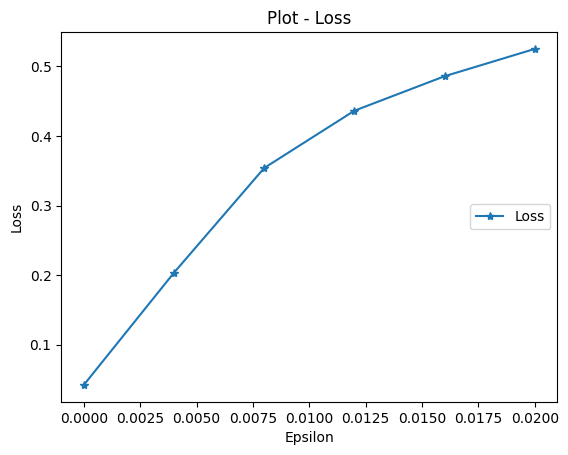

In [30]:
# Plot the result of the attack (accuracy vs epsilon) and (loss vs espislon)
# Loss plot
plt.plot(epsilons, loss, "*-", label="Loss")
plt.title("Plot - Loss")
plt.xlabel("Epsilon")
plt.ylabel("Loss")
plt.legend(loc='center right', shadow=False)
plt.savefig("loss plot FSGM.png", bbox_inches = 'tight', pad_inches=0.5)

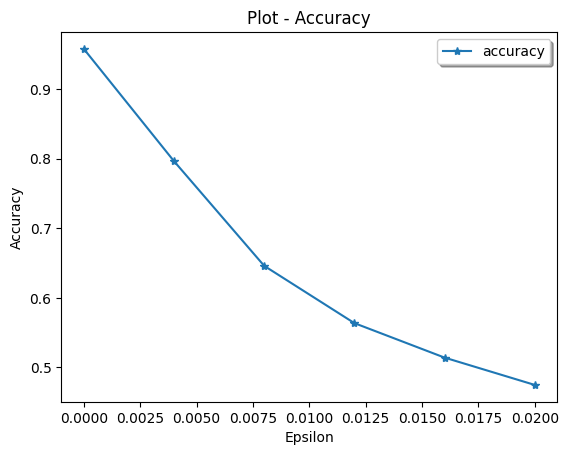

In [31]:
# Accuracy plot
plt.plot(epsilons, accuracy, "*-", label="accuracy")
plt.title("Plot - Accuracy")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend(loc='upper right', shadow=True)
plt.savefig("accurac plot FSGM.png", bbox_inches = 'tight', pad_inches=0.5)

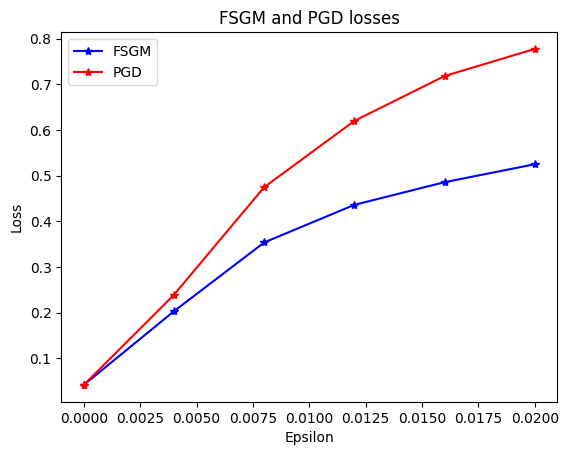

In [32]:
# FSGM vs PGD
plt.plot(epsilons, loss, "*-", label='FSGM', color='blue', )
plt.plot(epsilons, loss2, "*-", label='PGD', color='red')
plt.xlabel("Epsilon")
plt.ylabel("Loss")
plt.title("FSGM and PGD losses")
plt.legend()
plt.savefig("FSGM and PGD losses.png", bbox_inches = 'tight', pad_inches=0.5)